# Types of DSM

Demonstrates difference between DR and EE on load duration curve. Uses CISO 2022 data as example

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np

## Process 930 data

In [4]:
dfs = [
    pd.read_csv("./../../data/usa-2022/EIA930_BALANCE_2022_Jan_Jun.csv"),
    pd.read_csv("./../../data/usa-2022/EIA930_BALANCE_2022_Jul_Dec.csv"),
]
df = pd.concat(dfs)
# df = df[df["Region"] == "Cal"]

/tmp/ipykernel_607499/551080937.py:2: DtypeWarning: Columns (5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,25,26,27,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("./../../data/usa-2022/EIA930_BALANCE_2022_Jan_Jun.csv"),
/tmp/ipykernel_607499/551080937.py:3: DtypeWarning: Columns (5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,25,26,27,29,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("./../../data/usa-2022/EIA930_BALANCE_2022_Jul_Dec.csv"),


In [13]:
cal = df[df["Balancing Authority"] == "CISO"].copy()
cal['date_column'] = pd.to_datetime(cal['Data Date'], format='%m/%d/%Y')
cal['hour_column'] = cal['Hour Number'].astype(str).apply(lambda x: '00' if x == '24' else x)
cal = cal[~(cal['hour_column'] == "25")]
cal['datetime_column'] = cal['date_column'].dt.strftime('%Y-%m-%d') + ' ' + cal['hour_column'] + ':00:00'
cal['datetime_column'] = pd.to_datetime(cal['datetime_column'], format='%Y-%m-%d %H:%M:%S')
cal.head(3)

,Balancing Authority,Data Date,Hour Number,Local Time at End of Hour,UTC Time at End of Hour,Demand Forecast (MW),Demand (MW),Net Generation (MW),Total Interchange (MW),Sum(Valid DIBAs) (MW),...,Net Generation (MW) from Nuclear (Adjusted),Net Generation (MW) from All Petroleum Products (Adjusted),Net Generation (MW) from Hydropower and Pumped Storage (Adjusted),Net Generation (MW) from Solar (Adjusted),Net Generation (MW) from Wind (Adjusted),Net Generation (MW) from Other Fuel Sources (Adjusted),Region,date_column,hour_column,datetime_column
30402,CISO,01/01/2022,1,01/01/2022 1:00:00 AM,01/01/2022 9:00:00 AM,"22,631","22,321","13,064","-8,095","-8,095",...,"2,265",46.0,"1,235",-31,"2,729",231,CAL,2022-01-01,1,2022-01-01 01:00:00
30403,CISO,01/01/2022,2,01/01/2022 2:00:00 AM,01/01/2022 10:00:00 AM,"21,766","21,504","12,499","-8,003","-8,003",...,"2,265",46.0,"1,215",-31,"2,188",69,CAL,2022-01-01,2,2022-01-01 02:00:00
30404,CISO,01/01/2022,3,01/01/2022 3:00:00 AM,01/01/2022 11:00:00 AM,"21,105","21,050","11,790","-8,039","-8,039",...,"2,266",46.0,948,-31,"1,882",-56,CAL,2022-01-01,3,2022-01-01 03:00:00


## Extract out load 

In [22]:
load = cal.copy()
load = load.set_index("datetime_column")
load = load[["Demand (MW)", "Net Generation (MW) from Solar (Adjusted)", "Net Generation (MW) from Wind (Adjusted)"]]
load = load.rename(columns={
    "Net Generation (MW) from Solar (Adjusted)": "Solar (MW)", 
    "Net Generation (MW) from Wind (Adjusted)": "Wind (MW)"
})
load["Demand (MW)"] = load["Demand (MW)"].str.replace(",","").astype(float)
load["Original Load"] = load["Demand (MW)"] 
load["Solar (MW)"] = load["Solar (MW)"].str.replace(",","").astype(float)
load["Wind (MW)"] = load["Wind (MW)"].str.replace(",","").astype(float)
load["Net Load (MW)"] = load["Demand (MW)"] - load["Solar (MW)"] - load["Wind (MW)"]
load.head()

,Demand (MW),Solar (MW),Wind (MW),Original Load,Net Load (MW)
datetime_column,,,,,
2022-01-01 01:00:00,22321.0,-31.0,2729.0,22321.0,19623.0
2022-01-01 02:00:00,21504.0,-31.0,2188.0,21504.0,19347.0
2022-01-01 03:00:00,21050.0,-31.0,1882.0,21050.0,19199.0
2022-01-01 04:00:00,20874.0,-32.0,1693.0,20874.0,19213.0
2022-01-01 05:00:00,20895.0,-32.0,1433.0,20895.0,19494.0


<Axes: xlabel='Hour', ylabel='Load (MW)'>

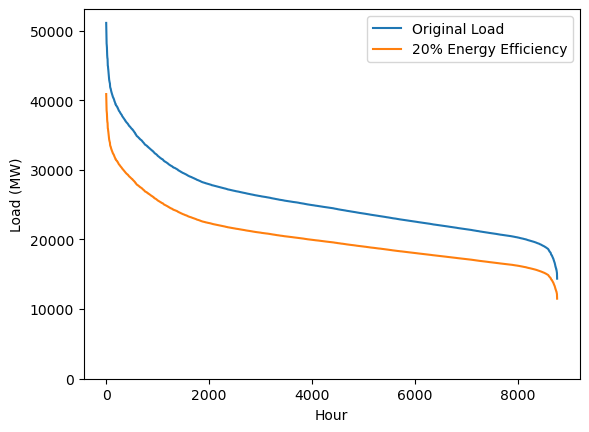

In [27]:
ee = load.copy()
ee = ee["Original Load"].reset_index(drop=True)
ee = pd.DataFrame(ee).sort_values(by="Original Load", ascending=False).dropna().reset_index(drop=True)
ee[r"20% Energy Efficiency"] = ee["Original Load"] * 0.80
ee.plot(ylabel="Load (MW)", ylim=0, xlabel="Hour")

<Axes: xlabel='Hour', ylabel='Load (MW)'>

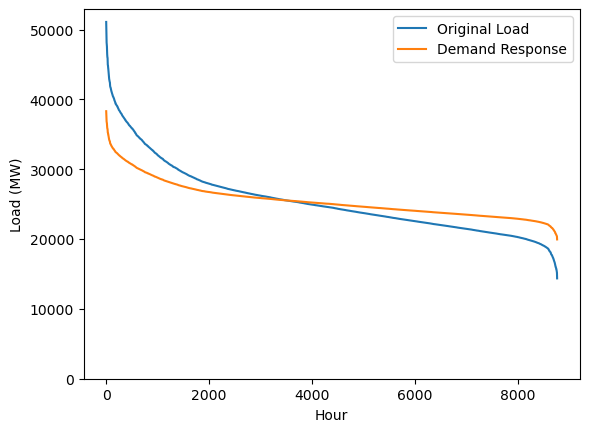

In [31]:
dr = load.copy()
dr = dr["Original Load"].reset_index(drop=True)
dr = pd.DataFrame(dr).sort_values(by="Original Load", ascending=False).dropna().reset_index(drop=True)
mean = dr.mean().iloc[0]
dr["Demand Response"] = ((dr["Original Load"] - mean) / 2) + mean
dr.plot(ylabel="Load (MW)", ylim=0, xlabel="Hour")

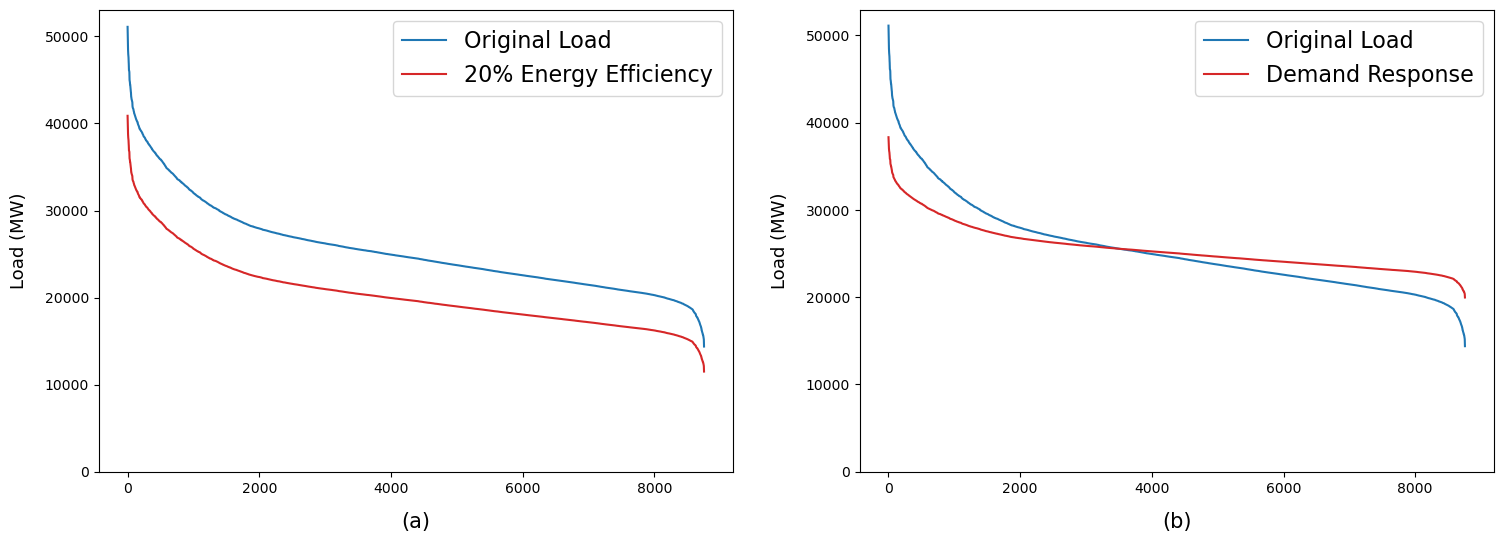

In [37]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18,6))
colormap = {
    "Original Load": "tab:blue",
    r"20% Energy Efficiency": "tab:red",
    "Demand Response": "tab:red",
}
ee.plot(
    ax = axs[0],
    color=colormap,
    ylim=0
)
dr.plot(
    ax = axs[1],
    color=colormap,
    ylim=0
)
axs[0].set_ylabel("Load (MW)", fontsize=13, labelpad=12)
axs[1].set_ylabel("Load (MW)", fontsize=13, labelpad=12)
axs[0].set_xlabel("(a)", fontsize=15, labelpad=12)
axs[1].set_xlabel("(b)", fontsize=15, labelpad=12)
axs[0].legend(fontsize="16", loc ="upper right")
axs[1].legend(fontsize="16", loc ="upper right")

fig.savefig("figures/ee-dr.png", dpi=400)